## Import and data loader

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
from matplotlib import cm

def load_polar(file):
    lidar = np.load(file)
    lidar = from_polar(preprocess(lidar).astype('float32'))
    
    length,_,_,_ = lidar.size()
    lidar = lidar.numpy()
    for n in range(length):
        for c in range(3):
            x = lidar[n,c,:,:]
            lidar[n,c,:,:] = np.interp(x, (x.min(), x.max()), (-1, 1))
    return torch.Tensor(lidar)
    #float32 should be used, but reducing for rapid prototyping

def load_CAD120(activity='having_meal'):
    data_path = 'data/Subject1_rgbd_images/%s/'%activity
    train_dataset = ImageFolder(
        root=data_path,
        transform=ToTensor()
    )
    return train_dataset
def load_CAD60(tag='train'):
    if tag=='train':
        #['0512164800', '0512165243', '0512165327', '0512170134', '0512171207', '0512171444', '0512171649', '0512172825', '0512173312', '0512173520', '0512173548', '0512173623', '0512174513', '0512174643', '0512174930', '0512175502']
        data_path = 'data2/data1/'
    elif tag=='test':
        data_path = 'data2/datatest'
    dataset = ImageFolder(
        root=data_path,
        transform=ToTensor()
    )
    return dataset

data = load_CAD60('test') #18,500 ; 1215
print(data)
del data
'''
train_loader = DataLoader(data
                    , batch_size = batch_size, shuffle=False, drop_last=True) 
for i,batch in enumerate(train_loader):
    if i%500==0:
        print(batch[1])
del train_loader
#print(load_CAD60('train')) #19851 datapoints in 16 vids around 1000
#print(load_CAD60('test')) #19851 datapoints in 1 vids around 1000
#print(len(load_CAD60('train')))
'''
print(' ')

Dataset ImageFolder
    Number of datapoints: 1351
    Root location: data2/datatest
    StandardTransform
Transform: ToTensor()
 


## Visualize

torch.Size([3, 240, 320])


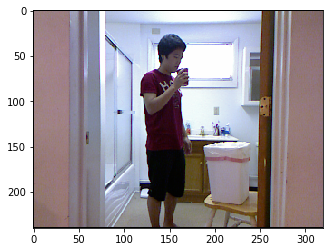

torch.Size([3, 240, 320])


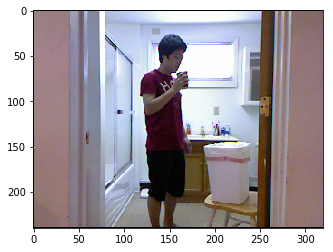

torch.Size([3, 240, 320])


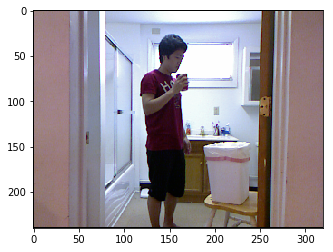

torch.Size([3, 240, 320])


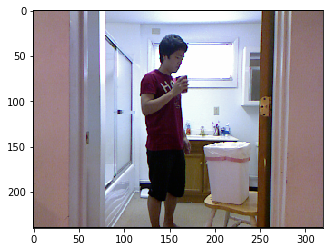

torch.Size([3, 240, 320])


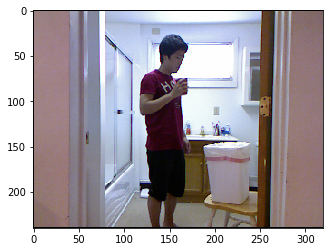

torch.Size([3, 240, 320])


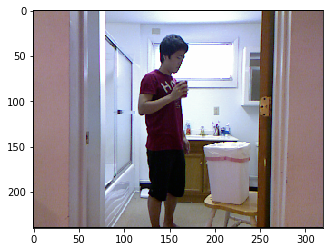

torch.Size([3, 240, 320])


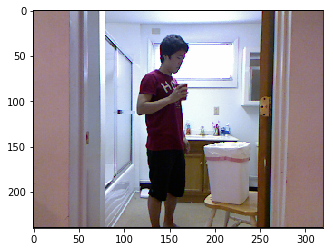

torch.Size([3, 240, 320])


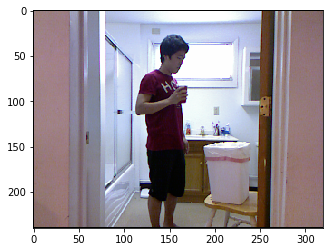

torch.Size([3, 240, 320])


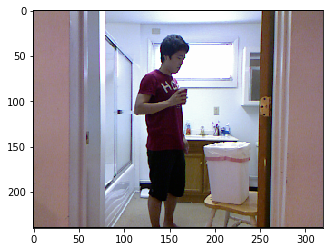

torch.Size([3, 240, 320])


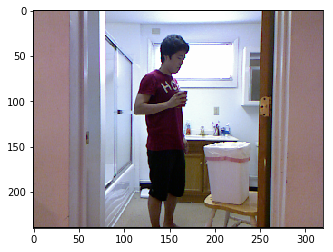

torch.Size([3, 240, 320])


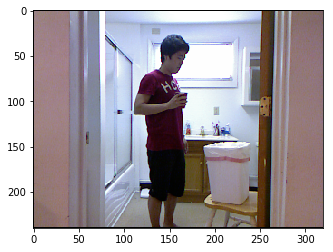

torch.Size([3, 240, 320])


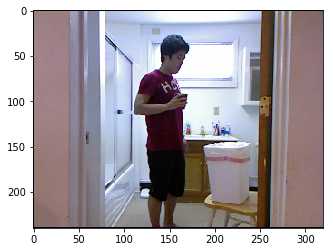

torch.Size([3, 240, 320])


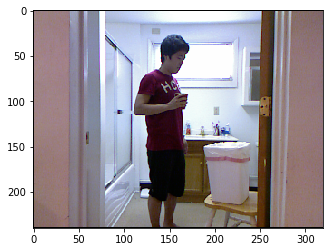

torch.Size([3, 240, 320])


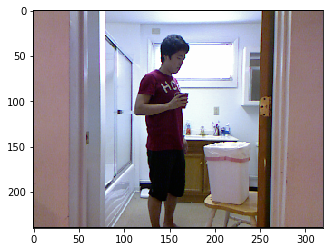

torch.Size([3, 240, 320])


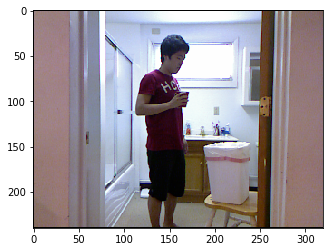

torch.Size([3, 240, 320])


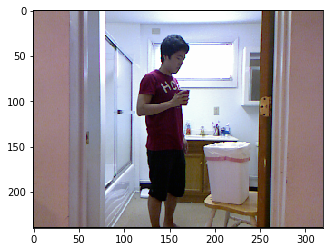

torch.Size([3, 240, 320])


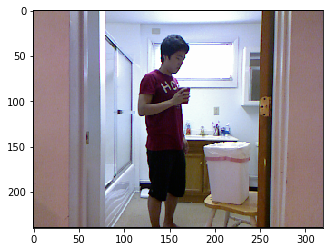

torch.Size([3, 240, 320])


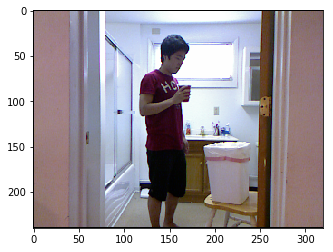

torch.Size([3, 240, 320])


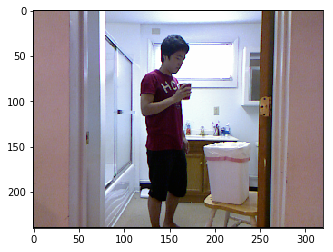

torch.Size([3, 240, 320])


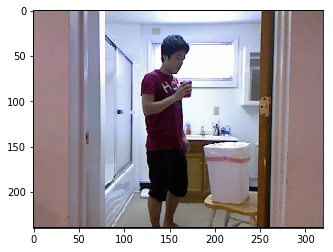

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm

dataset = load_CAD60()
for i in range(20):
    im = dataset[i][0]
    print(np.shape(im))
    #for i in range(3):
    #    plt.imshow(im[i,:,:], cmap=cm.gray)
    #    #plt.gcf().set_size_inches(16,16)
    #    plt.show()
    im = im.transpose(0,2).transpose(0,1)
    plt.imshow(im)
    #plt.gcf().set_size_inches(16,16)
    plt.show()

del dataset
del im

## VAE process and loss

In [91]:
class Regression(nn.Module):
    def __init__(self,batch):
        super(Regression,self).__init__(),
        self.linz  = nn.Linear(200*(10-batch),200*batch)
    def forward(self, zX, batch):
        n,c,h,w = zX.size()
        y=self.linz(zX.view(1,-1))
        y =y.view(batch,-1).unsqueeze(-1).unsqueeze(-1)
        return y
        


class VAE_encode(nn.Module):
    def __init__(self): #specify parameter functions to train 
        super(VAE_encode, self).__init__(),
        #instantiate,[10, 3,   40, 256]
        
        #layer 1, to [10, 64,  20, 128] 2(creates many layers)
        #layer 2, to [10, 128, 10, 64]  2(pulls content to new layers)
        #layer 3, to [10, 256,  5, 32]  2(pulls content to new layers)
        
        #layer 4, to [10, 512,  2, 16]  (3,4)(further reduces content for final layer)
        #layer 5, to [10, 100,  1, 1]   (2,16)(compression [do we want this?])
        
        #instantiate [10, 3, 480, 640]
        #[10,3,120,160] / 4x4
        #[10, 64,  60, 80] /2
        #[10, 256,  30, 40] /2
        #[10, 256,  15, 20] /2
        #[10, 512,  5, 20] / 3,2, #15,20 if I choose to compress before hand 
        #15,20 if 
        #23, 32
        
                
        #instantiate [10, 3, 240, 320]
        #[10,3,60,80] / 4x4
        #[10, 64,  30, 40] /2
        #[10, 256,  15, 20] /2
        #[10, 256,  5, 10] /3x2
        #[10, 512,  1, 1] / 5,10, #15,20 if I choose to compress before hand 
        #15,20 if 
        #23, 32
        
        
        #ENCODER1
        nc=3
        ndf=64
        nz = 200
        encode1_layers = []
        encode1_layers += [nn.Conv2d(nc,ndf, 8,4, 2, bias=False)]
        encode1_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode1_layers += [nn.Conv2d(ndf,ndf*2, 4, 2, 1, bias=False)]
        self.encoder1 = nn.Sequential(*encode1_layers)
        
        #ENCODER2
        encode2_layers = []
        encode2_layers += [nn.BatchNorm2d(ndf*2)]
        encode2_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode2_layers += [nn.Conv2d(ndf*2,ndf*4, 4,2, 1, bias=False)] 
        
        encode2_layers += [nn.BatchNorm2d(ndf*4)]
        encode2_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode2_layers += [nn.Conv2d(ndf * 4, ndf * 8, 4, (3,2), 1, bias=False)]
        
        encode2_layers += [nn.BatchNorm2d(ndf*8)]
        encode2_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode2_layers += [nn.Conv2d(ndf * 8,nz*2, (5,10),1, 0, bias=False)]
        self.encoder2 = nn.Sequential(*encode2_layers)  
        
        self.linz  = nn.Linear(nz*2,nz*2)
    
    def forward(self, x, training): #full vae forward path
        #print('encoding to amrr')
        x_amrr = self.encoder1(x)
        z = self.encoder2(x_amrr)
        n,c,h,w = z.size()
        #n = n*c*h*w
        #print(z.size())
        #print(z.view(n,-1).size())
        z = self.linz(z.view(n,-1)).unsqueeze(-1).unsqueeze(-1)
        
        mu,logvar = torch.chunk(z,2,dim=1)       
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if training==1:
            z = eps.mul(std).add_(mu)
        else:
            z = mu
        return z, mu, logvar 


class VAE_decode(nn.Module):
    def __init__(self): #specify parameter functions to train 
        super(VAE_decode, self).__init__(),
        #instantiate,[10, 3,   40, 256]
        
        #layer 1, to [10, 64,  20, 128] (creates many layers)
        #layer 2, to [10, 128, 10, 64]  (pulls content to new layers)
        #layer 3, to [10, 256,  5, 32]  (pulls content to new layers)
        
        #layer 4, to [10, 512,  2, 16]  (further reduces content for final layer)
        #layer 5, to [10, 100,  1, 1]   (compression [do we want this?])
                #uses 4 not 2
        #DECODER
        nz = 200 
        ngf = 64 
        nc = 3
        decode_layers = []
        decode_layers += [nn.ConvTranspose2d(nz,ngf*8,(5,10),1,0,bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*8)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf * 8, ngf * 4,4,(3,2),(1,1),bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*4)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf * 4, ngf * 2,4, 2, (0,1),bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*2)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf * 2, ngf * 1,4, 2, 1,bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*1)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf, nc,8, 4, 2,bias=False)]
        decode_layers += [nn.ReLU(True)]
        self.decoder = nn.Sequential(*decode_layers)
        
    
    def forward(self, z): #full vae forward path
        #print('decoding')
        x_pred = self.decoder(z)
        #print('decode size',x_pred.size())
        return x_pred
      
def Totalloss(mu,logvar,KLanneal,sample,data):    
    l,c,h,w = sample.size()
    x = sample.view(l,c,-1).transpose(0,1)
    y = data.view(l,c,-1).transpose(0,1)
    a = torch.sum(torch.sum((x[0]-y[0])**2,dim=-1))
    b = torch.sum(torch.sum((x[1]-y[1])**2,dim=-1))
    c = torch.sum(torch.sum((x[2]-y[2])**2,dim=-1))
    mse_loss = a+b+c
        
    KL = torch.sum(-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp(),dim=-1))
    return mse_loss + KLanneal*KL
    
    
def KLloss(mu, logvar):
    return torch.sum(-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp(),dim=-1))

def MSEloss(sample, data):
    l,c,h,w = sample.size()
    #try:
    x = sample.view(l,c,-1).transpose(0,1)
    y = data.view(l,c,-1).transpose(0,1)
    #except:
     #   x = sample.view(l,c).transpose(0,1)
      #  y = data.view(l,c).transpose(0,1)
    #sum of mean square errors for each channel
    a = torch.sum(torch.sum((x[0]-y[0])**2,dim=-1))
    b = torch.sum(torch.sum((x[1]-y[1])**2,dim=-1))
    c = torch.sum(torch.sum((x[2]-y[2])**2,dim=-1))
    #print('a: %.2f, b: %.2f, c: %.2f'%(a,b,c))
    mse_loss = a+b+c
    
    ''' 
    a=np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
    weight=torch.from_numpy(a).float().unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)
    sample_x = F.conv2d(sample, weight)
    data_x  = F.conv2d(data, weight)
    
    b=np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
    weight=torch.from_numpy(b).float().unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)
    sample_y = F.conv2d(sample, weight)
    data_y  = F.conv2d(data, weight)

    sample_grad=torch.sqrt(torch.pow(sample_x,2)+ torch.pow(sample_y,2))
    data_grad=torch.sqrt(torch.pow(data_x,2)+ torch.pow(data_y,2))
    
    edge_loss = F.mse_loss(sample_grad,data_grad)
    '''
    return mse_loss
        
    
    

## Training

loading data
 


EPOCH : 0


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


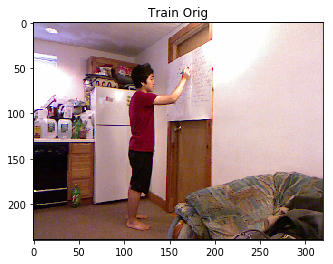

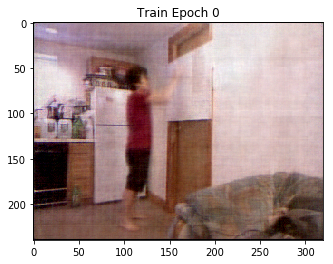

TypeError: forward() takes exactly 3 arguments (2 given)

In [92]:
print('loading data')

batch_size=10 #10 feasible, 20 waaaaay too slow
train_loader = DataLoader(load_CAD60('train')
                    , batch_size = batch_size, shuffle=False, drop_last=True) 
test_loader = DataLoader(load_CAD60('test')
                    , batch_size = batch_size, shuffle=False, drop_last=True) 
print(' ')


#the vae trains the convolution layers
network_encodeX = VAE_encode()
network_encodeY = VAE_encode()
network_decode = VAE_decode()
network_regression=Regression(1)

network_decode.load_state_dict(torch.load('decoder60_yoo_save'))
network_encodeX.load_state_dict(torch.load('encoderX60_yoo_save'))
network_encodeY.load_state_dict(torch.load('encoderY60_yoo_save'))

    

#Default 5e5
lr = 0.000005 #this should prevent the over
solver_encodeX = optim.Adam(network_encodeX.parameters(), lr=lr/2)#/2)
solver_encodeY = optim.Adam(network_encodeY.parameters(), lr=lr/2)#/2)
solver_decode = optim.Adam(network_decode.parameters(), lr=lr*5)
solver_regression = optim.Adam(network_regression.parameters(),lr=lr)
#network.eval() #changes batch normalization behavior

encoder_loss = []
decoder_loss = []
encoder_test = []
decoder_test = []

data_set = []
pred_set = []
z_set = []

Xidx = 5
epochs = 5
for epoch in range(epochs):
    print('\n\nEPOCH : %d\n\n'%epoch)
    batchcount = 0
    encoder_loss_temp, decoder_loss_temp = [],[]
    encoder_test_temp, decoder_test_temp = [],[]
    
    #sigmoid KL annealing [0.7% to 99.4%]
    #iff too big, fraction the anneal to enfoce regularization 
    KLanneal = 1/(1 + np.exp(5-epoch)) 
    
    for batch in train_loader: 
        ## ENCODE STEP
        #if batchcount%500==0:
        #    print('labels ',batch[1])
        
        ## DIVIDE BATCH
        batch = batch[0]
        batchY = torch.cat((batch[:Xidx],batch[Xidx+1:]),0)
        batchX = batch[Xidx]
        if len(batchX.size())<4:
            batchX = batchX.unsqueeze(0)

        ## ENCODE, MERGE LATENT SPACE
        solver_encodeX.zero_grad()
        solver_encodeY.zero_grad()
        zY, muY, logvarY = network_encodeY(batchY, training=1)
        zX, muX, logvarX = network_encodeX(batchX, training=1)
        
        solver_regression.zero_grad()
        zX_pred = network_regression(zY,1)
        regloss = torch.sum(torch.sum((zX_pred-zX)**2,dim=-1))
        regloss.backward()
        solver_regression.step()
        
        z = torch.cat((zY[:Xidx],zX_pred,zY[Xidx:]),0)
        loss1 = KLloss(muX,logvarX) + KLloss(muY,logvarY)
        
        ## DECODE STEP
        solver_decode.zero_grad()
        pred = network_decode(z)
        loss2 = MSEloss(pred, batch)
        
        ## SGD UPDATE (WITH ANNEAL)
        loss3 = loss2 + KLanneal*loss1
        #loss3.backward()
        #solver_encodeX.step()
        #solver_encodeY.step()
        #solver_decode.step()
        
        encoder_loss_temp.append(regloss.detach())
        #encoder_loss_temp.append(loss1.detach())
        decoder_loss_temp.append(loss2.detach())
        '''
        if epoch==epochs:
            if batchcount==0:
                z_set = z
            else:
                z_set = torch.cat((z_set,z),0)
        '''     
        batchcount+=1
        if batchcount%100==0:
            print('train batch %d'%batchcount)
       
            
    
    if epoch==0:
        im = batch[Xidx].detach().numpy()
        im = np.transpose(im, (1, 2, 0))
        plt.title('Train Orig')
        plt.imshow(im)
        plt.show()
    
    im = pred[Xidx].detach().numpy()
    im = np.clip(im,0,2)/im.max()
    im = np.transpose(im, (1, 2, 0))
    plt.title('Train Epoch %d'%epoch)
    plt.imshow(im)
    plt.show()

    
    encoder_loss.append(np.mean(encoder_loss_temp))
    decoder_loss.append(np.mean(decoder_loss_temp))
    batchcount = 0
    
    
    for batch2 in test_loader:
        ## ENCODE STEP
        batch2 = batch2[0]
        batchY2 = torch.cat((batch2[:Xidx],batch2[Xidx+1:]),0)
        batchX2 = batch2[Xidx]
        if len(batchX2.size())<4:
            batchX2 = batchX2.unsqueeze(0)
         
        zY2, muY2, logvarY2 = network_encodeY(batchY2, training=1)
        zX2, muX2, logvarX2 = network_encodeX(batchX2, training=1)
        
        zX2_pred = network_regression(zY2)
        regloss = torch.sum(torch.sum((zX2_pred-zX2)**2,dim=-1))
        
        z2 = torch.cat((zY2[:Xidx],zX2,zY2[Xidx:]),0)
        loss12 = KLloss(muX2,logvarX2) + KLloss(muY2,logvarY2)
        pred2 = network_decode(z2)
        loss22 = MSEloss(pred2, batch2)
        batchcount+=1
        if batchcount%100==0:
            print('test patch %d'%batchcount)
        encoder_test_temp.append(regloss.detach())
        decoder_test_temp.append(loss22.detach())

    if epoch==0:
        im2 = batch2[Xidx].detach().numpy()
        im2 = np.transpose(im2, (1, 2, 0))
        plt.title('Test Orig')
        plt.imshow(im2)
        plt.show()
        
   

    im2 = pred2[Xidx].detach().numpy()
    im2 = np.clip(im2,0,2)/im2.max()
    im2 = np.transpose(im2, (1, 2, 0))
    plt.title('Test Epoch %d'%epoch)
    plt.imshow(im2)
    plt.show()
    
    
    encoder_test.append(np.mean(encoder_test_temp))
    decoder_test.append(np.mean(decoder_test_temp))

    #if epoch==(epochs-1):
        #data_set.append(batch)
        #pred_set.append(pred)
        #mu_set.append(mu)
        #logvar_set.append(logvar)
#torch.save(z_set, 'z_set.pt')
#torch.save(network_encode.state_dict(), 'encoder60_yoo_save')
#torch.save(network_decode.state_dict(), 'decoder60_yoo_save')
torch.save(network_regression.state_dict(), 'regression_save')


## Plot

In [32]:
torch.save(network_encodeX.state_dict(), 'encoderX60_yoo_save')
torch.save(network_encodeY.state_dict(), 'encoderY60_yoo_save')

torch.save(network_decode.state_dict(), 'decoder60_yoo_save')

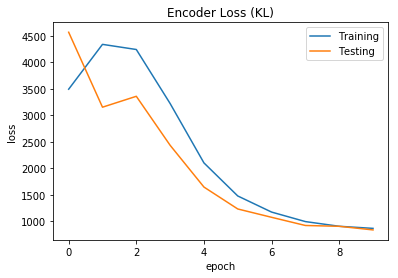

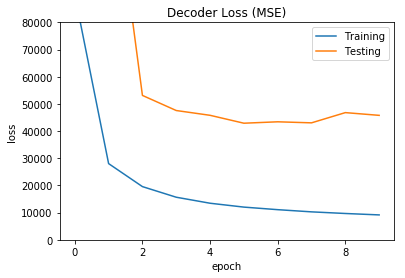

In [33]:
#Save Data
#np.save('data_set',np.array(data_set)) 
#np.save('pred_set',np.array(pred_set))
#np.save('mu_set',np.array(mu_set)) 
#np.save('logvar_set',np.array(logvar_set))


#Print
encoder_loss = np.array(encoder_loss)
decoder_loss = np.array(decoder_loss)
encoder_test = np.array(encoder_test)
decoder_test = np.array(decoder_test)


plt.plot(range(len(encoder_loss)),encoder_loss, label="Training")
plt.plot(range(len(encoder_test)),encoder_test, label="Testing")
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim((0,100))
plt.title('Encoder Loss (KL)')
plt.legend(loc="upper right")
plt.show()
#plt.savefig('training_loss.png')

plt.plot(range(len(decoder_loss)),decoder_loss, label="Training")
plt.plot(range(len(decoder_test)),decoder_test, label="Testing")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim((0,80000))
plt.title('Decoder Loss (MSE)')
plt.legend(loc="upper right")
plt.show()
#plt.savefig('training_loss.png')

## Vid Function 

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate(dataset, vidname):
    dataset = np.transpose(dataset,(0,2,3,1))
    dataset = np.clip(dataset,0,5)/dataset.max()
    
    #print('ani size ', np.shape(dataset))
    fig = plt.figure()
    ims = []
    for i in range(len(dataset)):
        im = plt.imshow(dataset[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)

    ani.save(vidname)
    #plt.show()
    
def printbatch(predcorr, corrbatch, alpha_spatial, all_colors, alpha_temporal):
    #Print image comparisons 
    
    corrstring='input_%s_%s_%s.mp4'%(str(alpha_spatial).split('.')[-1],str(all_colors),str(alpha_temporal).split('.')[-1])
    animate(corrbatch,corrstring)
    im = corrbatch[0]
    im = np.transpose(im, (1, 2, 0))
    plt.imshow(im)
    plt.title('Data %.2f spatial, %d allcolors, %.2f temporal'%(alpha_spatial, all_colors, alpha_temporal))
    plt.show()
     
    predstring='output_%s_%s_%s.mp4'%(str(alpha_spatial).split('.')[-1],str(all_colors),str(alpha_temporal).split('.')[-1])   
    animate(predcorr,predstring)    
    im = predcorr[0]
    im = np.clip(im,0,5)/im.max()
    im = np.transpose(im, (1, 2, 0))
    plt.imshow(im)
    plt.title('Recon, %.2f spatial, %d allcolors, %.2f temporal'%(alpha_spatial, all_colors, alpha_temporal))
    plt.show()
              
def printloss(encoder_ideal, decoder_ideal,encoder_corrupt,decoder_corrupt):
    #Print
    encoder_loss = np.array(encoder_ideal)
    decoder_loss = np.array(decoder_ideal)
    encoder_test = np.array(encoder_corrupt)
    decoder_test = np.array(decoder_corrupt)

    #print(encoder_loss)
    plt.plot(range(len(encoder_loss)),encoder_loss, label="Ideal")
    plt.plot(range(len(encoder_test)),encoder_test, label="Corrupt")
    plt.xlabel('alpha')
    plt.ylabel('loss')
    #plt.ylim((0,100))
    plt.title('Encoder Loss (KL)')
    plt.legend(loc="upper right")
    plt.show()
    #plt.savefig('training_loss.png')

    plt.plot(range(len(decoder_loss)),decoder_loss, label="Ideal")
    plt.plot(range(len(decoder_test)),decoder_test, label="Corrupt")
    plt.xlabel('alpha')
    plt.ylabel('loss')
    #plt.ylim((0,1))
    plt.title('Decoder Loss (MSE)')
    plt.legend(loc="upper right")
    plt.show()


## Corruption Test!

In [4]:
def corrupt(batch, alpha_spatial, all_colors, alpha_temporal): 
    n,c,h,w = batch.size()
    
    #spatial corruption   
    k_h = h*alpha_spatial
    k_w = h*alpha_spatial
    vec = np.ones((n,c,h,w))
    #channel selection 
    if all_colors==1:
        vec[0,:,int(h/4):int(h/4)+int(k_h),int(w/4):int(w/4)+int(k_w)] = 0
    else:  
        vec[0,0,int(h/4):int(h/4)+int(k_h),int(w/4):int(w/4)+int(k_w)] = 0
    vec = torch.Tensor(vec)
    corrupt = batch * vec
    
    #temporal corruption 
    k_t = n*alpha_temporal    
    corrupt[:int(k_t),:,:,:] = 0
    
    return corrupt

def runbatch(encoder_ideal, decoder_ideal,encoder_corrupt,decoder_corrupt,alpha_spatial, all_colors, alpha_temporal,printlast):
    #print('loading data')
    batch_size = 10
    loader = DataLoader(load_CAD60('train')
                        , batch_size = batch_size, shuffle=False, drop_last=True) 
    #print(' ')

    #network encode and decode are saved

    #the vae trains the convolution layers
    Xidx = 5
    network_encodeX = VAE_encode()
    network_encodeX.load_state_dict(torch.load('encoderX60_yoo_save'))
    network_encodeY = VAE_encode()
    network_encodeY.load_state_dict(torch.load('encoderY60_yoo_save'))
    network_decode = VAE_decode()
    network_decode.load_state_dict(torch.load('decoder60_yoo_save'))

    batchcount = 0
    encoder_ideal_temp,decoder_ideal_temp,encoder_corrupt_temp,decoder_corrupt_temp = [],[],[],[]
    

    
    mu_set, logvar_set = [],[]
    for i, batch in enumerate(loader): 
        if (0<=i and i<10) or (300<=i and i<310) or (600<=i and i<610) or (900<=i and i<910) or (1200<=i and i<1210):
        #if i<=100:
        #50-batch samples pulled from diverse scenes, visually meaningful
            #if i%500==0:
                #print('labels ',batch[1])
            batch = batch[0]                
            batchY = torch.cat((batch[:Xidx],batch[Xidx+1:]),0)
            batchX = batch[Xidx]
            if len(batchX.size())<4:
                batchX = batchX.unsqueeze(0)

            ## ENCODE, MERGE LATENT SPACE
            zY, muY, logvarY = network_encodeY(batchY, training=1)
            zX, muX, logvarX = network_encodeX(batchX, training=1)
            z = torch.cat((zY[:Xidx],zX,zY[Xidx:]),0)
            loss1 = KLloss(muX,logvarX) + KLloss(muY,logvarY)

            ## DECODE STEP
            pred = network_decode(z)
            loss2 = MSEloss(pred, batch)
            encoder_ideal_temp.append(loss1.detach())
            decoder_ideal_temp.append(loss2.detach())

            corrX = corrupt(batchX, alpha_spatial=alpha_spatial, all_colors = all_colors, alpha_temporal=alpha_temporal)
            zX, muX, logvarX = network_encodeX(corrX, training=1)
            z = torch.cat((zY[:Xidx],zX,zY[Xidx:]),0)
            loss1 = KLloss(muX,logvarX) + KLloss(muY,logvarY)
            predcorr = network_decode(z)
            loss2 = MSEloss(predcorr, batch)
            encoder_corrupt_temp.append(loss1.detach())
            decoder_corrupt_temp.append(loss2.detach())
            #batchcount+=1
            if i%500==0: 
                print('batch %d'%i)
        
            corrbatch = torch.cat((batchY[:Xidx],corrX,batchY[Xidx:]),0)
            if i==0:
                #z_set = z
                #muX_set = muX
                #muY_set = muY
                #logvarX_set =logvarX 
                #logvarY_set = logvarY
                corrbatch_set = corrbatch.detach().numpy()
                pred_set = predcorr.detach().numpy()
            else: #elif i< 100: #2000 frames!
                #z_set = torch.cat((z_set,z),0)
                #muX_set = torch.cat((muX_set,muX),0)
                #muY_set = torch.cat((muY_set,muY),0)
                #logvarX_set =torch.cat((logvarX_set,logvarX),0)
                #logvarY_set = torch.cat((logvarY_set,logvarY),0)
                corrbatch_set = np.concatenate((corrbatch_set,corrbatch.detach().numpy()),axis=0)
                pred_set = np.concatenate((pred_set,predcorr.detach().numpy()),axis=0)
            
               
            
            #np.concatenate((mu_set,mu.detach().numpy()),axis=0)
            #np.concatenate((logvar_set,logvar.detach().numpy()),axis=0)
        else:
            if i%500==0: 
                print('batch %d'%i)
     
    #torch.save(muX_set, 'muX_set.pt')
    #torch.save(muY_set, 'muY_set.pt')
    #torch.save(logvarX_set, 'logvarX_set.pt')
    #torch.save(logvarY_set, 'logvarY_set.pt')

    #Save loss     
    encoder_ideal.append(np.mean(encoder_ideal_temp))
    decoder_ideal.append(np.mean(decoder_ideal_temp))
    encoder_corrupt.append(np.mean(encoder_corrupt_temp))
    decoder_corrupt.append(np.mean(decoder_corrupt_temp))
    if printlast==1:
        #print(np.shape(pred_set))
        printbatch(pred_set,corrbatch_set,alpha_spatial, all_colors, alpha_temporal)
    return encoder_ideal, decoder_ideal,encoder_corrupt,decoder_corrupt
    

def test_corrupt(alpha_spatial_list=[0.0], alpha_temporal_list=[0.0]):
    '''
    for all_colors in [0,1]:
        alpha_temporal=0
        encoder_ideal,decoder_ideal,encoder_corrupt, decoder_corrupt = [],[],[],[]
        for i,alpha_spatial in enumerate(alpha_spatial_list):
            if i==1 or i==2 or i==3:
                printlast=1
            else:
                printlast=0
            runbatch(encoder_ideal, decoder_ideal,encoder_corrupt,decoder_corrupt, alpha_spatial, all_colors, alpha_temporal,printlast)
        print('Spatial Loss, allcolors=%d'%all_colors)
        printloss(encoder_ideal, decoder_ideal,encoder_corrupt,decoder_corrupt)
    '''     
    alpha_spatial=0
    all_colors=0
    encoder_ideal,decoder_ideal,encoder_corrupt, decoder_corrupt = [],[],[],[]
    for i,alpha_temporal in enumerate(alpha_temporal_list):
        if i==0 or i==1 or i==2 or i==3:
            printlast=1
        else:
            printlast=0
        runbatch(encoder_ideal, decoder_ideal,encoder_corrupt,decoder_corrupt, alpha_spatial, all_colors, alpha_temporal,printlast)
    print('Temporal Loss')
    printloss(encoder_ideal, decoder_ideal,encoder_corrupt,decoder_corrupt)



## Plot Corruption

batch 0
batch 500
batch 1000
batch 1500


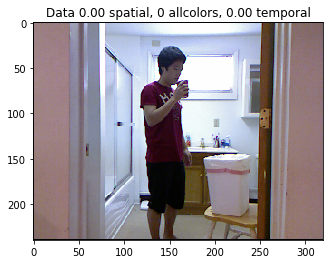

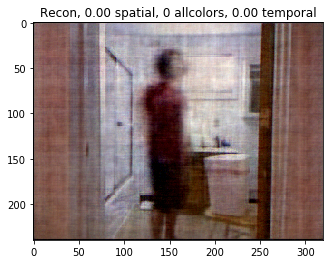

batch 0
batch 500
batch 1000
batch 1500


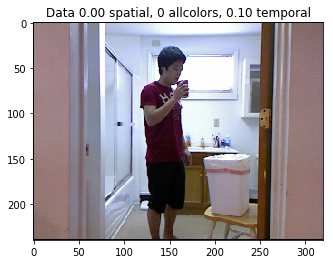

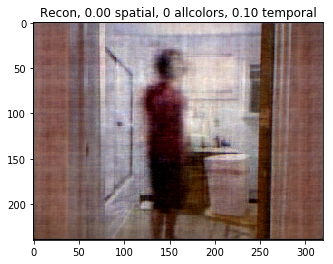

batch 0
batch 500
batch 1000
batch 1500


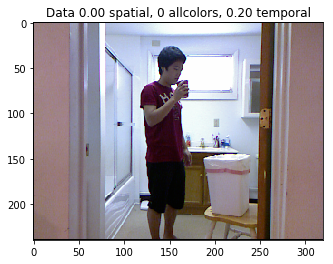

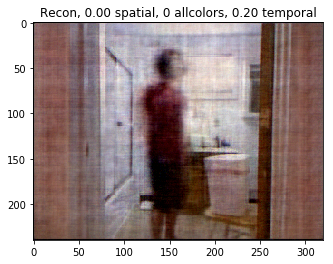

batch 0
batch 500
batch 1000
batch 1500


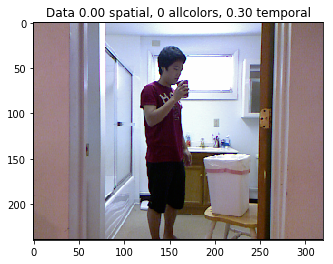

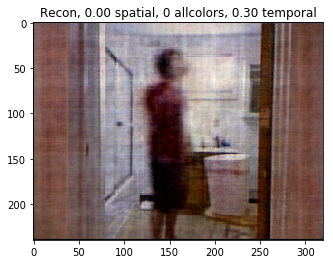

batch 0
batch 500
batch 1000
batch 1500
batch 0
batch 500
batch 1000
batch 1500
Temporal Loss


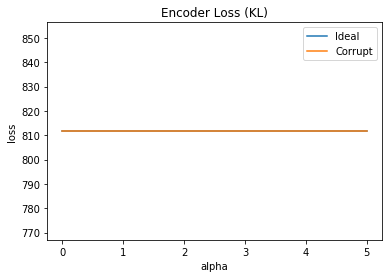

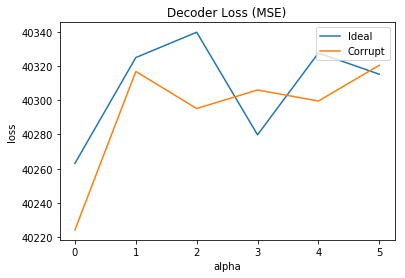

In [5]:
test_corrupt(alpha_spatial_list=[0.0,0.1,0.2,0.3,0.4,0.5], alpha_temporal_list=[0.0,0.1,0.2,0.3,0.4,0.5])
#test_corrupt([0.0],[0.0])
#test_corrupt(alpha_spatial_list=[0.0,0.1,0.2,0.3,0.4,0.5], alpha_temporal_list=[0.0,0.1,0.2,0.3,0.4,0.5])

In [ ]:
train seperately

zy after training
zx 


In [9]:
test = [0,1,2,3,4]
print(test[0:2])
print(test[2])
print(test[2+1:])
print(test[0:])

[0, 1]
2
[3, 4]
[0, 1, 2, 3, 4]


In [6]:
printloss(encoder_ideal, decoder_ideal,encoder_corrupt,decoder_corrupt)


NameError: name 'encoder_ideal' is not defined

## Reconstruction from z_y to Y obtained via GP

In [32]:
def printy(Y_set, pred_y_set,pred_gp_set,pred_gp_y_set):
    #Print image comparisons 
    
    print(np.shape(Y_set))
    print(np.shape(pred_y_set))
    print(np.shape(pred_gp_set))
    print(np.shape(pred_gp_y_set))
    Y_set = Y_set[0]
    pred_y_set = pred_y_set[0]
    pred_gp_set = pred_gp_set[0]
    pred_gp_y_set = pred_gp_y_set[0]
    
    corrstring='input'
    im = np.transpose(Y_set, (1, 2, 0))
    plt.imshow(im)
    plt.title('Data ')
    plt.show()
     
    predstring='output_y' 
    im = np.clip(pred_y_set,0,5)/pred_y_set.max()
    im = np.transpose(im, (1, 2, 0))
    plt.imshow(im)
    plt.title('Recon_y')
    plt.show()
    
    predstring='output_gp' 
    im = np.clip(pred_gp_set,0,5)/pred_gp_set.max()
    im = np.transpose(im, (1, 2, 0))
    plt.imshow(im)
    plt.title('Recon_gp')
    plt.show()
    
    predstring='output_gp_y' 
    im = np.clip(pred_gp_y_set,0,5)/pred_gp_y_set.max()
    im = np.transpose(im, (1, 2, 0))
    plt.imshow(im)
    plt.title('Recon_gp_y')
    plt.show()
              
def printlossy(decoder_y,decoder_gp,decoder_gp_y):
    #Print
    decoder_y = np.array(decoder_y)
    decoder_gp = np.array(decoder_gp)
    decoder_gp_y = np.array(decoder_gp_y)


    #print(encoder_loss)
    plt.plot(range(len(decoder_gp)),decoder_y, label="Reg VAE")
    plt.plot(range(len(decoder_gp)),decoder_gp, label="GP VAE")
    plt.plot(range(len(decoder_gp_y)),decoder_gp_y, label="GP_Y VAE")

    plt.xlabel('image')
    plt.ylabel('loss')
    #plt.ylim((0,100))
    plt.title('Decoder Loss (MSE)')
    plt.legend(loc="upper right")
    plt.show()
    #plt.savefig('training_loss.png')


In [47]:
def runy(decoder_y,decoder_gp,decoder_gp_y,printlast):
    #print('loading data')
    batch_size = 10
    z_gp = torch.tensor(np.load('learned_z.npy')).unsqueeze(-1).unsqueeze(-1)
    z_gp_y = torch.tensor(np.load('learned_z_withy.npy')).unsqueeze(-1).unsqueeze(-1)
    z_orig = torch.load('z_set.pt')
    print(z_gp.size())
    print(z_gp_y.size())
    print(z_orig.size())
    
    indexer = 5+10*np.array(range((len(z_orig)-5)/10))
    #z_y = z_orig[indexer,:,:,:]
   
    batch_size=10
    loader = DataLoader(load_CAD60('train')
                        , batch_size = 10, shuffle=False, drop_last=True) 

    #the vae trains the convolution layers
    Xidx = 5
    network_decode = VAE_decode()
    network_decode.load_state_dict(torch.load('decoder60_yoo_save'))
    network_encode = VAE_encode()
    network_encode.load_state_dict(torch.load('encoderY60_yoo_save'))
    
    network_regression = Regression()
    network_regression.load_state_dict(torch.load('regression_save'))
    
    z_idx = -1
    mu_set, logvar_set = [],[]
    for i, batch in enumerate(loader): 
        #if (0<=i and i<10) or (300<=i and i<310) or (600<=i and i<610) or (900<=i and i<910) or (1200<=i and i<1210):
        if (400<=i and i<500):
            
            
            batch = batch[0]
            batchX = torch.cat((batch[:Xidx],batch[Xidx+1:]),0)
            Y = batch[Xidx]


            zX, _, _ = network_encode(batchX, training=1)
            x = batchX.reshape(9,-1)
            z_gp_y = network_regression(x)       
            
            
            z_idx += 1
            Y = batch[0][Xidx]
            z_y_loc,_,_ = network_encode(Y.unsqueeze(0), training=1)
            z_gp_loc = z_gp[z_idx]
            z_gp_y_loc = z_gp_y[z_idx]
            if len(Y.size())<4:
                Y = Y.unsqueeze(0)
            if len(z_y_loc.size())<4:
                z_y_loc = z_y_loc.unsqueeze(0)
            if len( z_gp_loc.size())<4:
                 z_gp_loc =  z_gp_loc.unsqueeze(0)
            if len( z_gp_y_loc.size())<4:
                 z_gp_y_loc =  z_gp_y_loc.unsqueeze(0)

            ## DECODE STEP
            pred_y = network_decode(z_y_loc)
            pred_gp = network_decode(z_gp_loc)
            pred_gp_y = network_decode(z_gp_y_loc)
            
            loss_y = MSEloss(pred_y, Y)
            loss_gp = MSEloss(pred_gp, Y)
            loss_gp_y = MSEloss(pred_gp_y, Y)
            
            decoder_y.append(loss_y.detach())
            decoder_gp.append(loss_gp.detach())
            decoder_gp_y.append(loss_gp_y.detach())

            #batchcount+=1
            if (printlast==1) and (i%5==0):
                printy(Y.detach().numpy(),pred_y.detach().numpy(),pred_gp.detach().numpy(),pred_gp_y.detach().numpy())
            if i%500==0: 
                print('batch %d'%i)
        else:
            if i%500==0: 
                print('batch %d'%i)

    return decoder_y,decoder_gp,decoder_gp_y
    

decoder_y,decoder_gp,decoder_gp_y = [],[],[]
runy(decoder_y,decoder_gp,decoder_gp_y,1)
printlossy(decoder_y,decoder_gp,decoder_gp_y)



torch.Size([100, 200, 1, 1])
torch.Size([100, 200, 1, 1])
torch.Size([500, 200, 1, 1])
batch 0


RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 212336640000 bytes. Error code 12 (Cannot allocate memory)


In [ ]:
import numpy as np
learned_z = np.load('learned_z.npy')
learned_z_withy = np.load('learned_z_withy.npy')

In [6]:
print(np.shape(learned_z))
print(np.shape(learned_z_withy))


(100, 200)
(100, 200)


loading data
('Xidx: ', [3, 4, 5])
('xx: ', 2)


EPOCH : 0


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


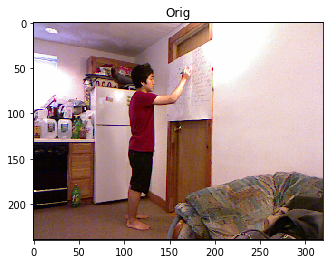

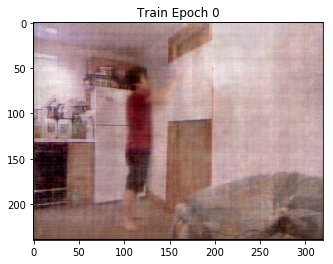



EPOCH : 1


train batch 100
train batch 200
train batch 300
train batch 400
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


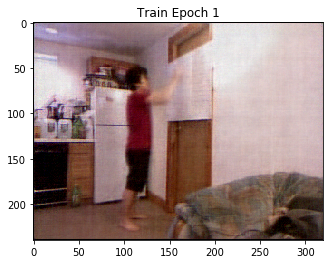



EPOCH : 2


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


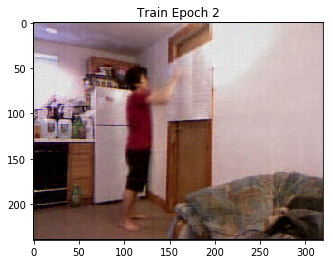



EPOCH : 3


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


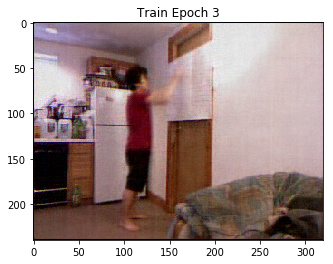



EPOCH : 4


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


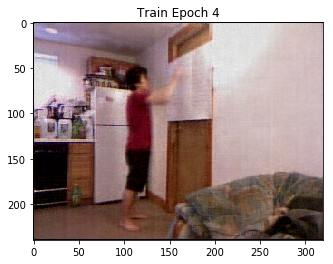



EPOCH : 5


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


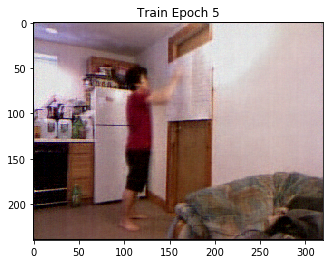



EPOCH : 6


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


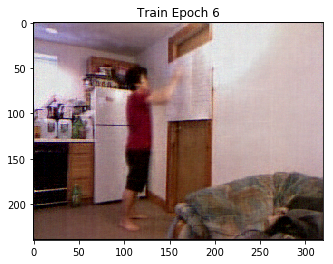



EPOCH : 7


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


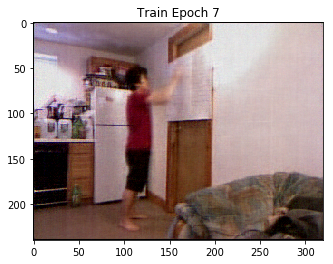



EPOCH : 8


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


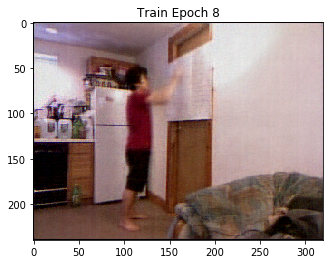



EPOCH : 9


train batch 100
train batch 200
train batch 300
train batch 400
train batch 500
train batch 600
train batch 700
train batch 800
train batch 900
train batch 1000
train batch 1100
train batch 1200
train batch 1300
train batch 1400
train batch 1500
train batch 1600
train batch 1700
train batch 1800


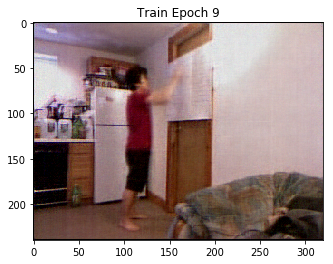

In [124]:
print('loading data')

batch_size=10 #10 feasible, 20 waaaaay too slow
train_loader = DataLoader(load_CAD60('train')
                    , batch_size = batch_size, shuffle=False, drop_last=True) 


#the vae trains the convolution layers
network_encodeX = VAE_encode()
network_encodeY = VAE_encode()
network_decode = VAE_decode()

network_decode.load_state_dict(torch.load('decoder60_yoo_save'))
network_encodeX.load_state_dict(torch.load('encoderX60_yoo_save'))
network_encodeY.load_state_dict(torch.load('encoderY60_yoo_save'))

    
#Default 5e5
lr = 0.000005 #this should prevent the over
solver_encodeX = optim.Adam(network_encodeX.parameters(), lr=lr/2)#/2)
solver_encodeY = optim.Adam(network_encodeY.parameters(), lr=lr/2)#/2)
solver_decode = optim.Adam(network_decode.parameters(), lr=lr*5)
#network.eval() #changes batch normalization behavior

encoder_loss = []
decoder_loss = []
encoder_test = []
decoder_test = []

data_set = []
pred_set = []
z_set = []

Xidx = 5
epochs = 10

#Xidx_set = [[5],[5,6],[4,5,6],[4,5,6,7],[3,4,5,6,7]]
Xidx_set = [[3,4,5]]
for xminor, Xidx in enumerate(Xidx_set):
    xx = 2
    print('Xidx: ',Xidx)
    print('xx: ',xx)
    network_regression=Regression(xx+1)
    solver_regression = optim.Adam(network_regression.parameters(),lr=lr)

    encoder_loss=[]
    decoder_loss=[]
    decoder_defloss=[]
    
    for epoch in range(epochs):
        batchcount=0
        print('\n\nEPOCH : %d\n\n'%epoch)
        if 1==1:#(0<=i and i<10) or (300<=i and i<310) or (600<=i and i<610) or (900<=i and i<910) or (1200<=i and i<1210):

            encoder_loss_temp, decoder_loss_temp = [],[]
            decoder_defloss_temp = []

            #sigmoid KL annealing [0.7% to 99.4%]
            #iff too big, fraction the anneal to enfoce regularization 
            KLanneal = 1/(1 + np.exp(5-epoch)) 

            for i, batch in enumerate(train_loader): 
                
                ## DIVIDE BATCH
                batch = batch[0]
                
                idx1 = Xidx[0]
                idx2 = Xidx[-1]+1
                batchY = torch.cat((batch[:idx1],batch[idx2:]),0)
                batchX = batch[idx1:idx2]
                if len(batchX.size())<4:
                    batchX = batchX.unsqueeze(0)

                ## ENCODE, MERGE LATENT SPACE
                zY, muY, logvarY = network_encodeY(batchY, training=1)
                zX, muX, logvarX = network_encodeX(batchX, training=1)

                solver_regression.zero_grad()
                zX_pred = network_regression(zY,xx+1)
                regloss = torch.sum(torch.sum((zX_pred-zX)**2,dim=-1))
                regloss.backward()
                solver_regression.step()

                z = torch.cat((zY[:idx1],zX_pred,zY[idx1:]),0)
                pred = network_decode(z)
                loss2 = MSEloss(pred, batch)
                if epoch==0 and i==1849 and xx==5:
                    z_default = torch.cat((zY[:idx1],zX,zY[idx1:]),0)
                    preddef = network_decode(z_default)
                    animate(batch.detach().numpy(),'decoder_orig_vid.mp4')
                    animate(preddef.detach().numpy(),'decoder_default_vid.mp4')
                elif epoch==0 and i==1849:
                    animate(pred.detach().numpy(),'decoder_pred_vid_%d.mp4'%xx)
                #loss2def = MSEloss(preddef, batch)
                

                encoder_loss_temp.append(regloss.detach())
                decoder_loss_temp.append(loss2.detach())
                #decoder_defloss_temp.append(loss2def.detach())
                
                
                batchcount+=1
                if batchcount%100==0:
                    print('train batch %d'%batchcount)


        if epoch==0:
            im = batch[Xidx[0]+1].detach().numpy()
            im = np.transpose(im, (1, 2, 0))
            plt.title('Orig')
            plt.imshow(im)
            plt.show()
        
        im = pred[Xidx[0]+1].detach().numpy()
        im = np.clip(im,0,2)/im.max()
        im = np.transpose(im, (1, 2, 0))
        plt.title('Train Epoch %d'%epoch)
        plt.imshow(im)
        plt.show()
        '''
        im = preddef[Xidx[0]].detach().numpy()
        im = np.clip(im,0,2)/im.max()
        im = np.transpose(im, (1, 2, 0))
        plt.title('Default Epoch %d'%epoch)
        plt.imshow(im)
        plt.show()
        '''

        
        encoder_loss.append(np.mean(encoder_loss_temp))
        decoder_loss.append(np.mean(decoder_loss_temp))
        #decoder_defloss.append(np.mean(decoder_defloss_temp))
      
    encodername = 'encoder_loss_%d'%xx
    np.save(encodername,encoder_loss)
    decodername = 'decoder_loss_%d'%xx
    np.save(decodername,decoder_loss)
    #decoderdefname = 'decoder_defloss_%d'%xx
    #np.save(decoderdefname,decoder_defloss)


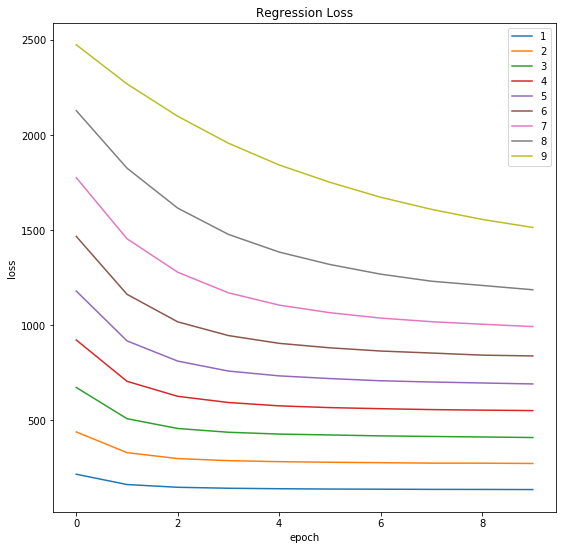

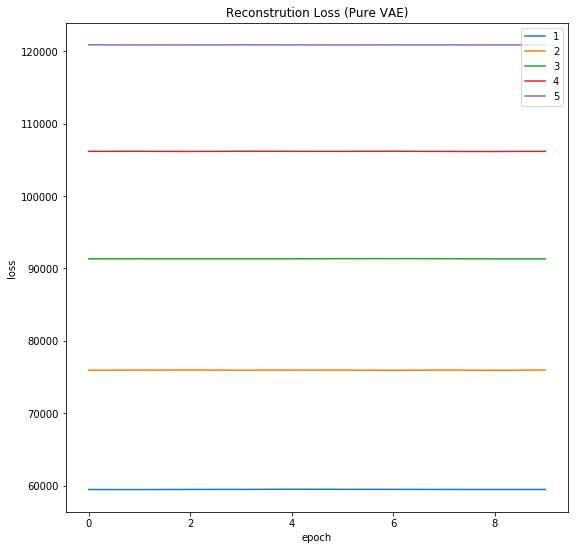

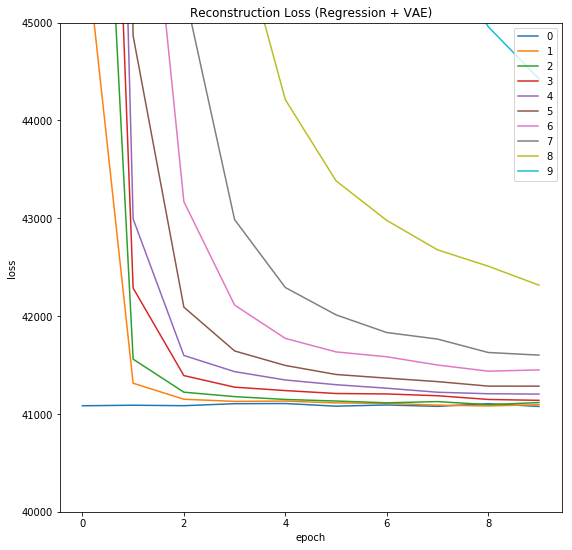

In [122]:
loss0 = np.load('decoder_original.npy')
for opt in range(3):

    if opt==0:
        ## Regression Training 
        base = 'encoder_loss_'  
        title = 'Regression Loss'
    elif opt==1:
        ## Decoding from Default VAE
        base = 'decoder_defloss_'
        title = 'Reconstrution Loss (Pure VAE)'
    elif opt==2:
        ## Decoding from Regression
        base = 'decoder_loss_'
        title = 'Reconstruction Loss (Regression + VAE)'

    ##RUN

    loss1 = np.load('%s%d.npy'%(base,0))
    loss2 = np.load('%s%d.npy'%(base,1))
    loss3 = np.load('%s%d.npy'%(base,2))
    loss4 = np.load('%s%d.npy'%(base,3))
    loss5 = np.load('%s%d.npy'%(base,4))
    x = range(len(loss1))
    plt.figure(figsize=[9,9])
    if opt==2:
        loss0 = np.load('decoder_original.npy')
        plt.plot(x,loss0,label="0")
    plt.plot(x,loss1, label="1")
    plt.plot(x,loss2, label="2")
    plt.plot(x,loss3, label="3")
    plt.plot(x,loss4, label="4")
    plt.plot(x,loss5, label="5")
    if opt!=1:
        loss6 = np.load('%s%d.npy'%(base,5))
        loss7 = np.load('%s%d.npy'%(base,6))
        loss8 = np.load('%s%d.npy'%(base,7))
        loss9 = np.load('%s%d.npy'%(base,8))
        plt.plot(x,loss6, label="6")
        plt.plot(x,loss7, label="7")
        plt.plot(x,loss8, label="8")
        plt.plot(x,loss9, label="9")
        

    plt.xlabel('epoch')
    plt.ylabel('loss')
    if opt==2:
        plt.ylim((40000,45000))
    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()


In [96]:
encodername = 'encoder_loss_%d'%xx
np.save(encodername,encoder_loss)
decodername = 'decoder_loss_%d'%xx
np.save(decodername,decoder_loss)
decoderdefname = 'decoder_defloss_%d'%xx
np.save(decoderdefname,decoder_defloss)

In [97]:
batch_size=10 #10 feasible, 20 waaaaay too slow
train_loader = DataLoader(load_CAD60('train')
                    , batch_size = batch_size, shuffle=False, drop_last=True) 
for i,batch in enumerate(train_loader):
    pass
print(i)

1849
